In [602]:
# Reading the input file
import pandas as pd
df = pd.read_excel("Speed Dating Data-v1.6.xls")

In [603]:
# Checking for null values
df.isna().sum()

iid            0
gender         0
pid            0
match          0
int_corr     158
samerace       0
age_o         94
race_o        63
pf_o_att      79
pf_o_sin      79
pf_o_int      79
pf_o_fun      88
pf_o_amb      97
pf_o_sha     119
attr_o       202
sinc_o       277
intel_o      296
fun_o        350
amb_o        712
shar_o      1066
age           94
diff_age       0
field_cd      82
race          63
imprace       79
imprelig      79
zipcode     1063
goal          79
career_c      89
sports        79
tvsports      79
exercise      79
dining        79
museums       79
art           79
hiking        79
gaming        79
clubbing      79
reading       79
tv            79
theater       79
movies        79
concerts      79
music         79
shopping      79
yoga          79
attr1_1       79
sinc1_1       79
intel1_1      79
fun1_1        88
amb1_1        97
shar1_1      119
attr         202
sinc         277
intel        296
fun          350
amb          712
shar        1066
dtype: int64

In [604]:
# Removing null values using Iterative Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import seaborn as sns

null_columns = ['int_corr', 'samerace', 'age_o',
       'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb',
       'pf_o_sha', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o',
       'age', 'diff_age', 'field_cd', 'race', 'imprace', 'imprelig', 'zipcode',
       'goal', 'career_c', 'sports', 'tvsports', 'exercise', 'dining',
       'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv',
       'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'attr1_1',
       'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'attr', 'sinc',
       'intel', 'fun', 'amb', 'shar']
impute_it = IterativeImputer()
impute_data = impute_it.fit_transform(df[null_columns])
df[null_columns] = impute_data

In [605]:
# Checking if there are any null values left
df.isna().sum().sum()

0

# Defining preprocessing methods

In [606]:
# Removing outliers
from sklearn.ensemble import IsolationForest

def remove_outliers(df_subset):
    ifd = IsolationForest(n_estimators=50, warm_start=True)
    ifd.fit(df_subset)  

    print(df_subset.shape)
    df_subset = df_subset[ifd.predict(df_subset) == 1]

    print(df_subset.shape)

    # Defining dependent and independent variables
    X = df_subset.drop(['match'], axis = 1)
    y = df_subset['match'].reset_index(drop = True)

    print(X.shape, y.shape)
    return X,y

In [607]:
# Applying SMOTE
from imblearn.over_sampling import SMOTE

def apply_smote(X,y):
    k=3
    seed=100
    sm = SMOTE(sampling_strategy='auto',k_neighbors=k, random_state=16)
    X, y = sm.fit_resample(X,y)

    print(X.shape)
    print(y.shape)
    return X,y

In [608]:
# Transformation
from sklearn.preprocessing import MinMaxScaler

def min_max_scaling(X,y):
    min_max_scaler = MinMaxScaler()
    X = min_max_scaler.fit_transform(X,y)
    return X

# KNN Model

In [609]:
# Displaying roc curve, precision recall and confusion matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

def display_confusion_matrix(model, X_test, y_test):
    _,ax=plt.subplots(2,2,figsize=(16,16))
    RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax[0][0])
    PrecisionRecallDisplay.from_estimator(model,X_test,y_test,ax=ax[0][1])
    ConfusionMatrixDisplay.from_estimator(model,X_test,y_test, ax=ax[1][0],colorbar=False, cmap='YlGn')
    ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,normalize='true',ax=ax[1][1],colorbar=False, cmap='YlGn',values_format='.4f')
    ax[1][0].set_title('Confusion Matrix in Counts')
    ax[1][1].set_title('Confusion Matrix in Proportion')
    plt.show()

In [610]:
# Calculating CV score on entire data

from sklearn.model_selection import cross_validate

def get_cv_score(model, X, y):
    cv_score = cross_val_score(model, X, y, cv=5)
    return cv_score.mean()

In [611]:
#KNN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def knn_model(X_train, X_test, y_train, y_test, neighbors, weights, algorithm):
    print("K-NEAREST NEIGHBORS")
    knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    print("Training score: ", score)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy: ", acc)
    display_confusion_matrix(knn, X_test, y_test)
    training_cv_score = get_cv_score(knn, X_train, y_train)
    print("CV mean score of Training dataset: ", training_cv_score)
    testing_cv_score = get_cv_score(knn, X_test, y_test)
    print("CV mean score of Testing dataset: ", testing_cv_score)

In [612]:
#Getting best parameters to perform KNN- Hyper Parameter Tuning

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV



def get_best_params_knn(X_train, X_test, y_train, y_test):
    
    k_range = list(range(1, 31))
    param_grid = {'n_neighbors': k_range, 'weights': ('uniform', 'distance'), 'algorithm':('auto', 'ball_tree', 'kd_tree')},
    print("K-NEAREST NEIGHBORS")
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', return_train_score=False,verbose=1)
    grid_search.fit(X_train, y_train)
    print('Best parameters: ', grid_search.best_params_)
    best_params = grid_search.best_params_
    knn_model(X_train, X_test, y_train, y_test, best_params['n_neighbors'], 
                                       best_params['weights'], best_params['algorithm'])

In [613]:
# Defining test and training variables to run models before preprocessing

from sklearn.model_selection import train_test_split

X = df.drop('match', axis=1)
y = df['match']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)


K-NEAREST NEIGHBORS
Training score:  0.8183990442054958
Accuracy:  0.8183990442054958


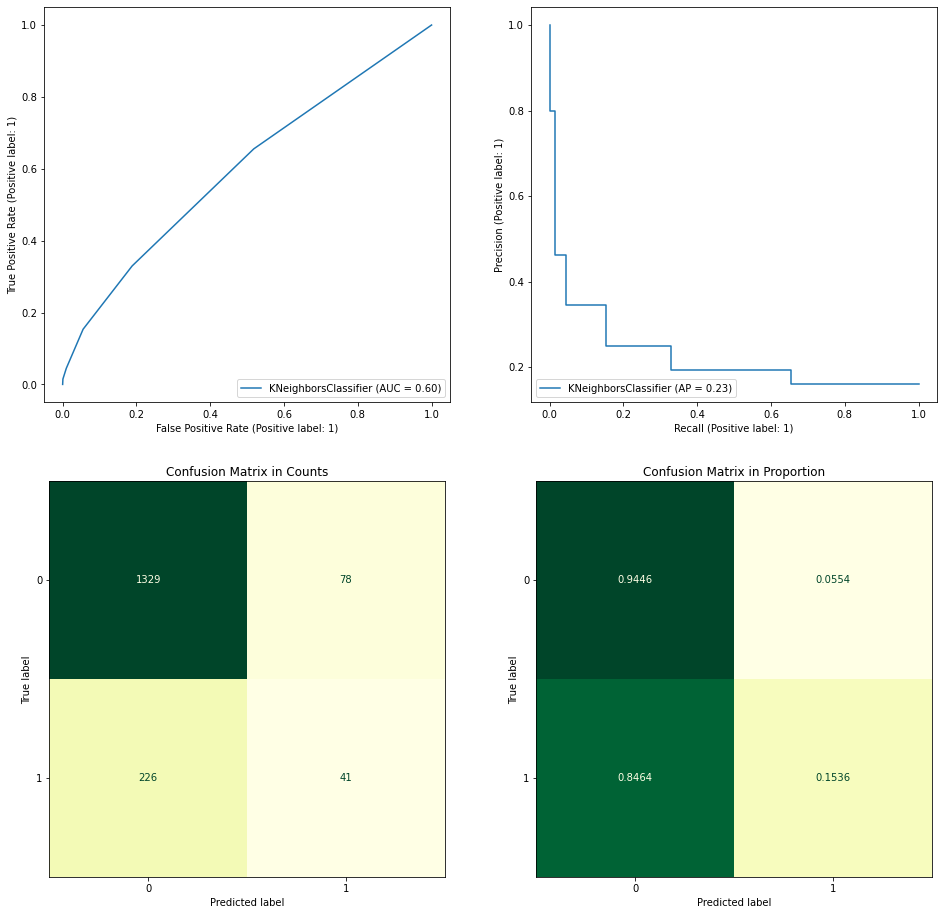

CV mean score of Training dataset:  0.8137135782788618
CV mean score of Testing dataset:  0.8177996246313344


In [614]:
# Running KNN before preprocessing

knn_model(X_train, X_test, y_train, y_test, 5, 'uniform', 'auto')

In [ ]:
########################################################################################

# FEATURE SELECTION USING CORRELATION

########################################################################################

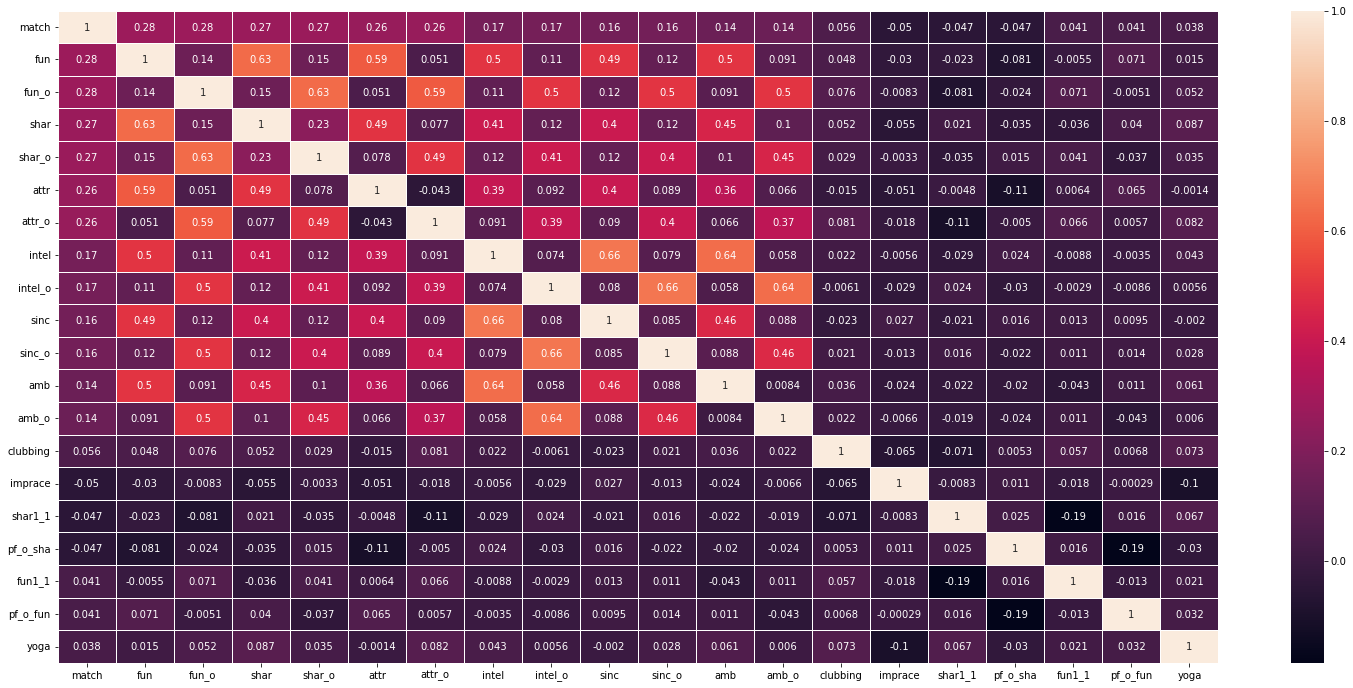

In [615]:
# Selecting most correlated features
df_corr = df.corr().dropna()
subset_index = df_corr["match"].abs().sort_values(ascending = False)[:20].index.tolist()
df_subset = df[subset_index]
df_subset_corr = df_subset.corr()
fig, ax = plt.subplots(figsize=(26,12))
sns.heatmap(df_subset_corr, linewidths=.5, annot=True, ax = ax)
plt.show()

(8368, 19) (8368,)
K-NEAREST NEIGHBORS
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters:  {'algorithm': 'ball_tree', 'n_neighbors': 13, 'weights': 'uniform'}
K-NEAREST NEIGHBORS
Training score:  0.8339307048984468
Accuracy:  0.8339307048984468


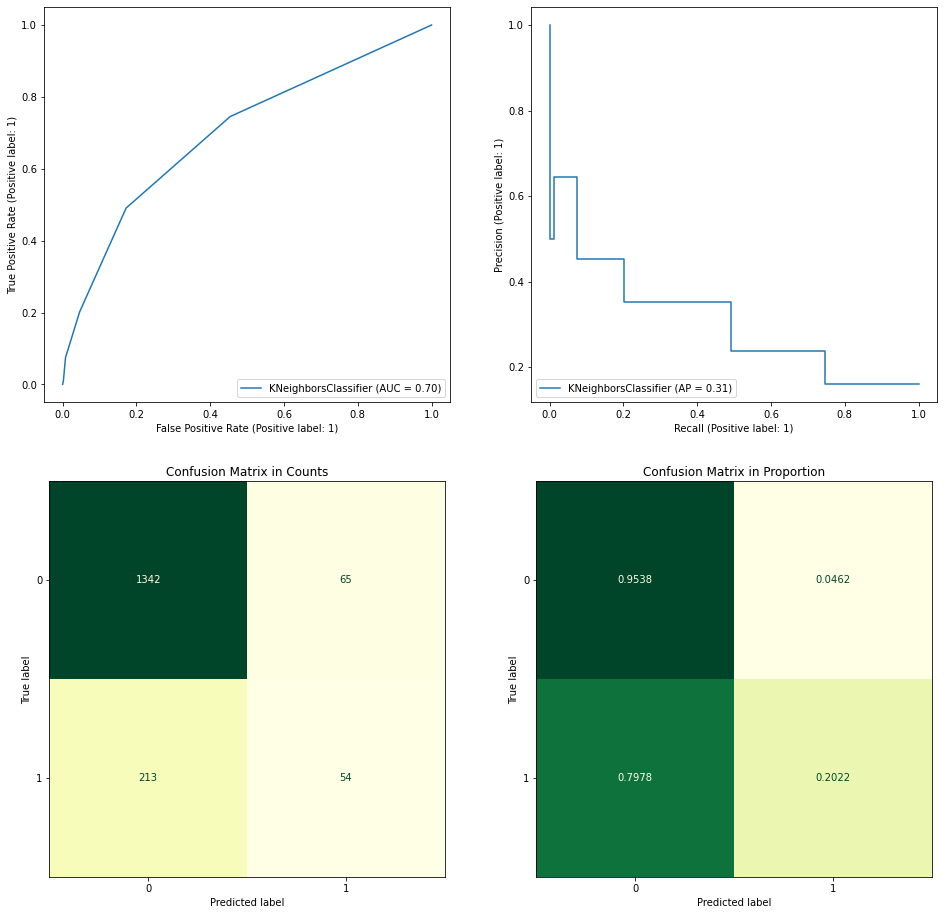

CV mean score of Training dataset:  0.8313417973612148
CV mean score of Testing dataset:  0.8363178121369202


In [616]:
# Running KNN model after feature selection

X = df_subset.drop(['match'], axis = 1)
y = df_subset['match'].reset_index(drop = True)

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)
get_best_params_knn(X_train, X_test, y_train, y_test)

In [618]:
# Removing outliers

X,y = remove_outliers(df_subset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)


(8368, 20)
(7032, 20)
(7032, 19) (7032,)


K-NEAREST NEIGHBORS
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters:  {'algorithm': 'auto', 'n_neighbors': 14, 'weights': 'distance'}
K-NEAREST NEIGHBORS
Training score:  0.8372423596304194
Accuracy:  0.8372423596304194


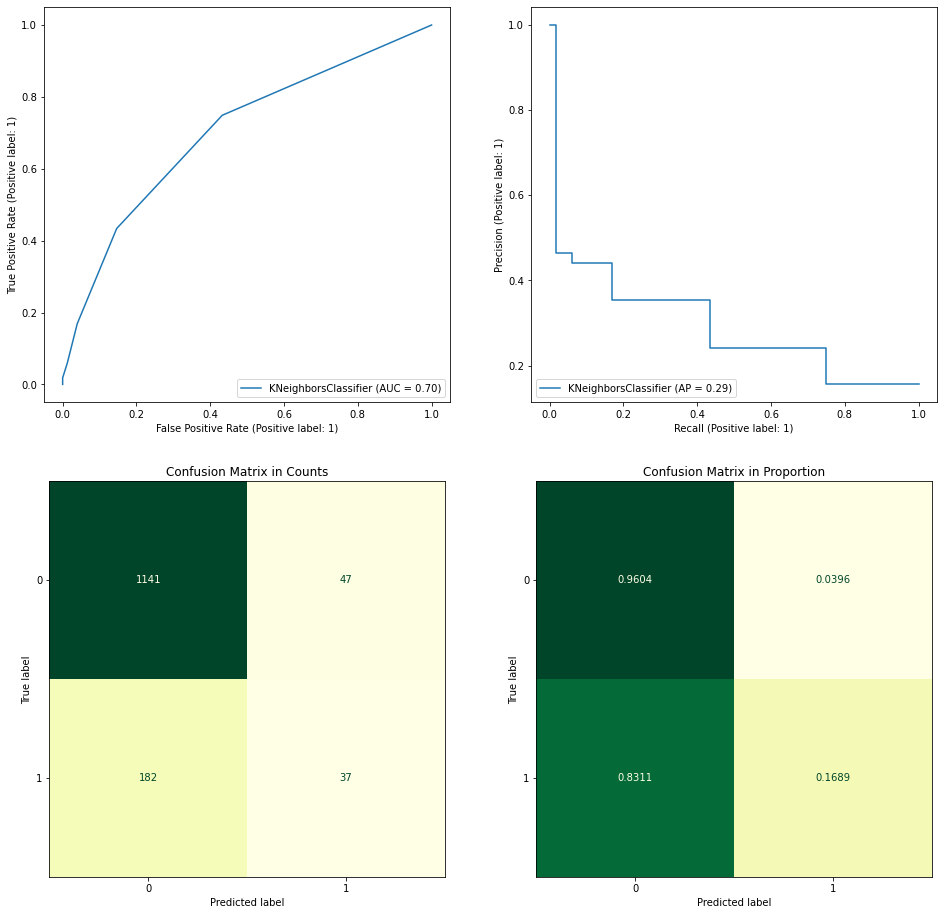

CV mean score of Training dataset:  0.8476444444444444
CV mean score of Testing dataset:  0.8159208500542642


In [619]:
# Running KNN after removing outliers

get_best_params_knn(X_train, X_test, y_train, y_test)

In [620]:
# Applying SMOTE

X,y = apply_smote(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)


(12012, 19)
(12012,)


K-NEAREST NEIGHBORS
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters:  {'algorithm': 'auto', 'n_neighbors': 2, 'weights': 'uniform'}
K-NEAREST NEIGHBORS
Training score:  0.8168955472326259
Accuracy:  0.8168955472326259


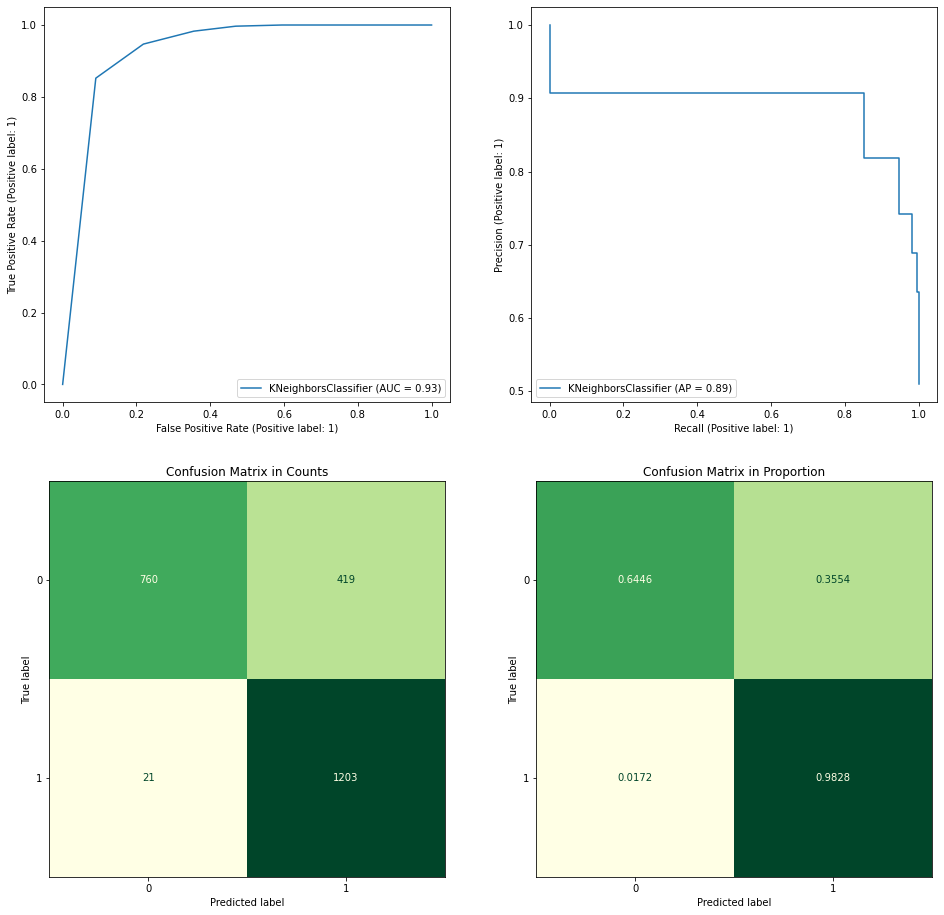

CV mean score of Training dataset:  0.8000842866591444
CV mean score of Testing dataset:  0.7269984407484407


In [621]:
# Running KNN after applying SMOTE

get_best_params_knn(X_train, X_test, y_train, y_test)

In [622]:
# Transformation

X = min_max_scaling(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)


K-NEAREST NEIGHBORS
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters:  {'algorithm': 'auto', 'n_neighbors': 2, 'weights': 'uniform'}
K-NEAREST NEIGHBORS
Training score:  0.8281315022888056
Accuracy:  0.8281315022888056


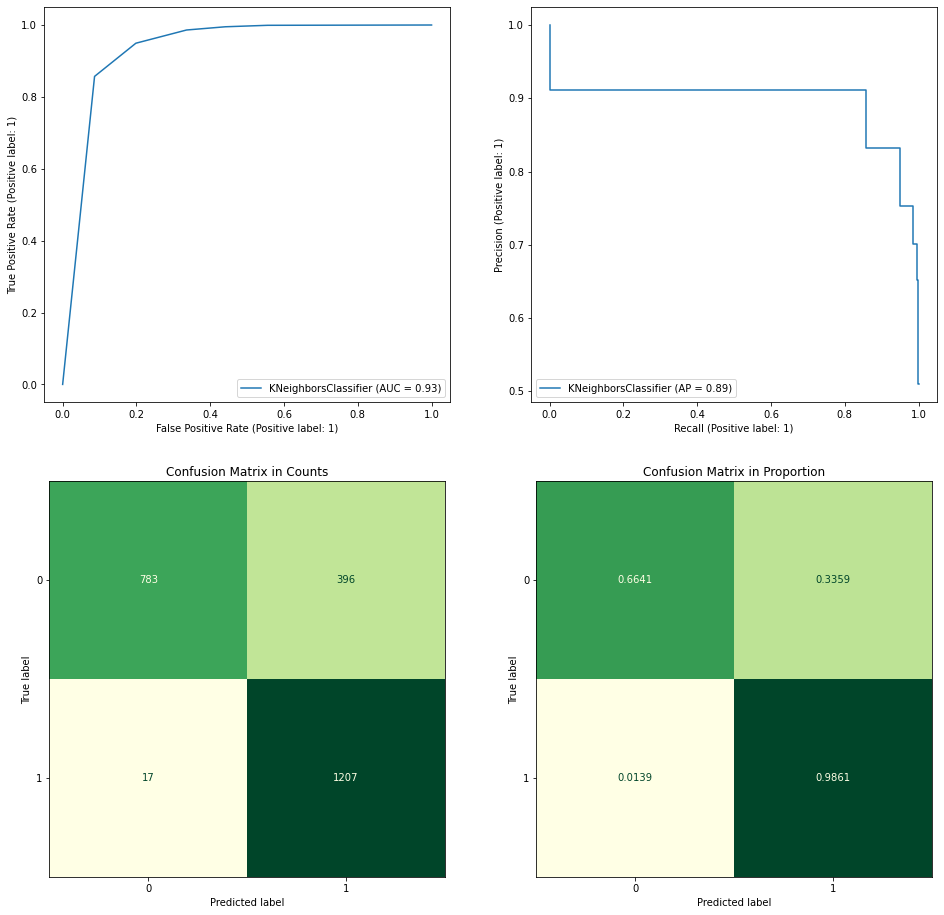

CV mean score of Training dataset:  0.8194422129906543
CV mean score of Testing dataset:  0.7665375952875954


In [623]:
# Running models after selection most correlated features and preprocessing

get_best_params_knn(X_train, X_test, y_train, y_test)

In [ ]:
########################################################################################

# FEATURE SELECTION USING INFORMATION GAIN

########################################################################################

In [624]:
# Defining dependent and independent variables

X_mutual = df.drop(['match', 'iid', 'pid'], axis=1)
y_mutual = df['match']

<AxesSubplot:>

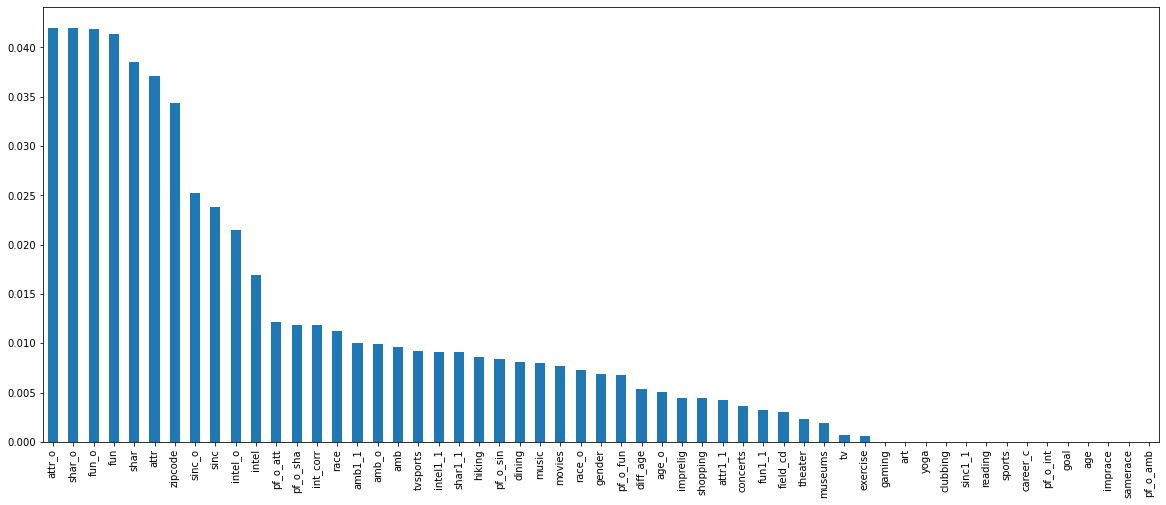

In [625]:
# Calculating mutual information gain of all features

X_train, X_test, y_train, y_test = train_test_split(X_mutual, y_mutual, test_size = 0.2, random_state = 16)
from sklearn.feature_selection import mutual_info_classif

# Determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

# Plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))



In [626]:
# Selecting top 30 features with most information gain

mutual_info_columns = mutual_info.nlargest(30).index.tolist()
df_mutual = df[mutual_info_columns]
df_mutual['match'] = df['match']
print(df_mutual.shape)

(8368, 31)


/var/folders/z5/nh_hftln6w5bwkr7w4q3q4380000gn/T/ipykernel_55007/3091428966.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mutual['match'] = df['match']


In [627]:
# Defining dependent and independent variables
X = df_mutual.drop(['match'], axis = 1)
y = df_mutual['match'].reset_index(drop = True)

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)

(8368, 30) (8368,)


K-NEAREST NEIGHBORS
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters:  {'algorithm': 'auto', 'n_neighbors': 18, 'weights': 'uniform'}
K-NEAREST NEIGHBORS
Training score:  0.8231780167264038
Accuracy:  0.8231780167264038


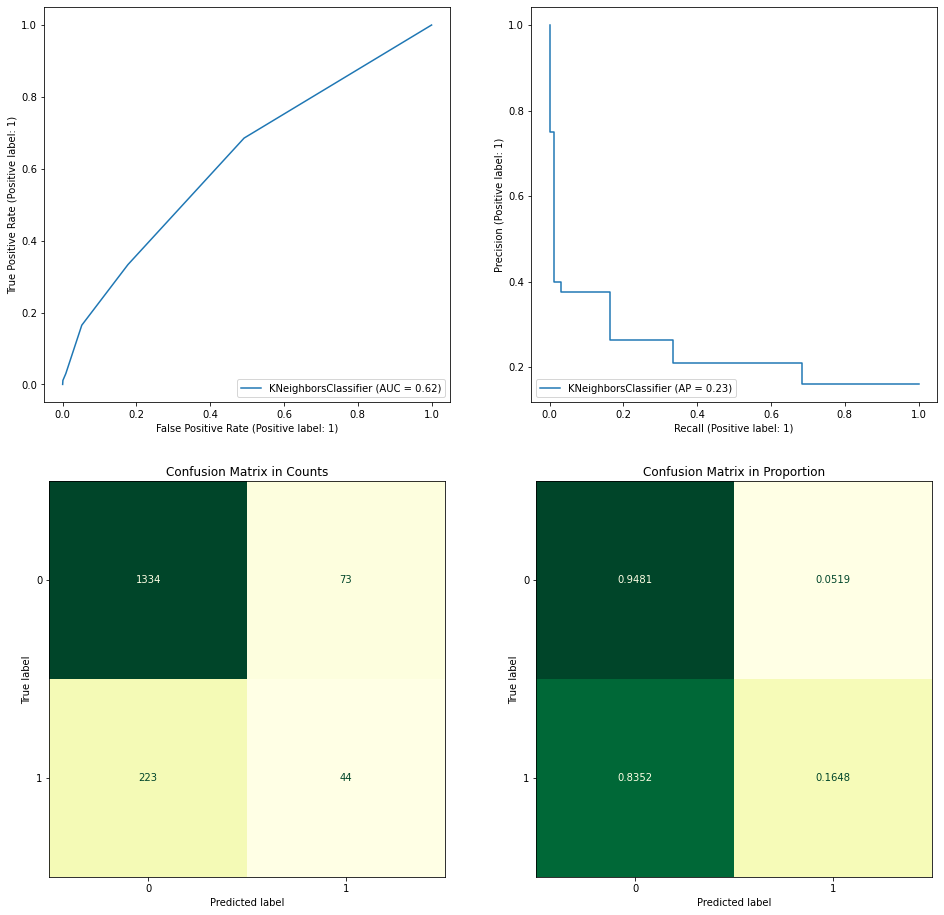

CV mean score of Training dataset:  0.8208848939094052
CV mean score of Testing dataset:  0.8201930467423362


In [628]:
# Running models after feature selection information gain

get_best_params_knn(X_train, X_test, y_train, y_test)

In [630]:
# Removing outliers

X,y = remove_outliers(df_mutual)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)

(8368, 31)
(7715, 31)
(7715, 30) (7715,)


K-NEAREST NEIGHBORS
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters:  {'algorithm': 'auto', 'n_neighbors': 28, 'weights': 'uniform'}
K-NEAREST NEIGHBORS
Training score:  0.830200907323396
Accuracy:  0.830200907323396


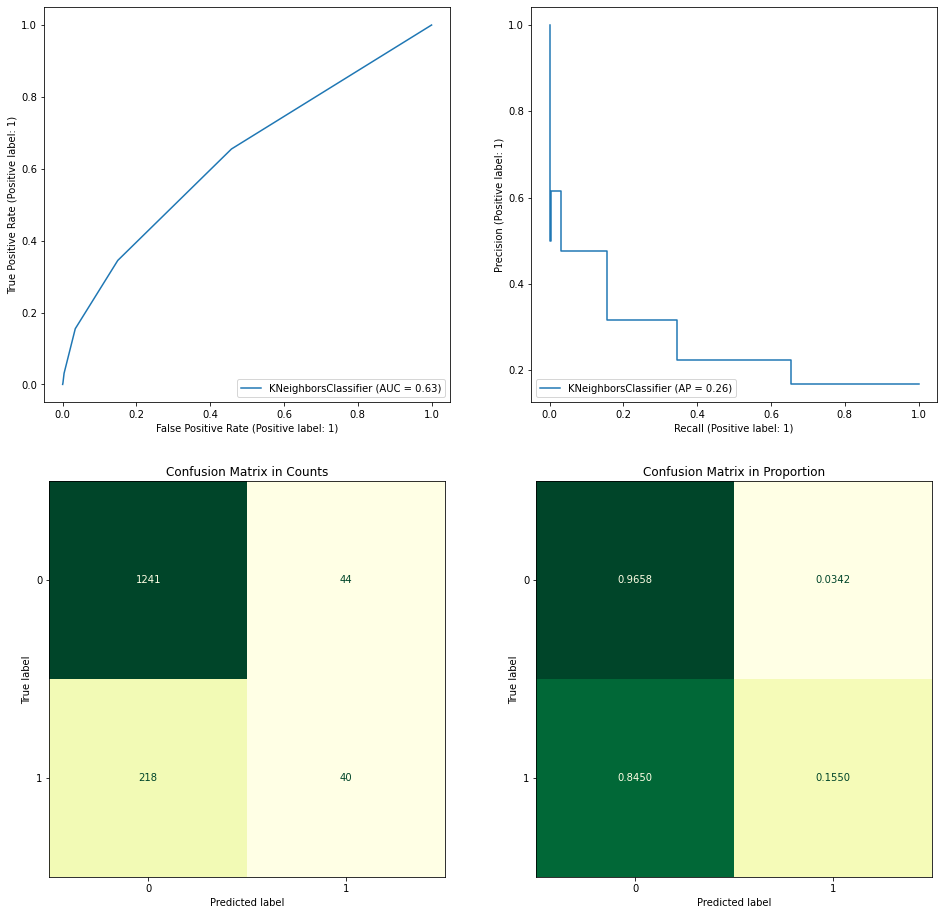

CV mean score of Training dataset:  0.8329571716349845
CV mean score of Testing dataset:  0.810763669986971


In [631]:
# Running KNN model after removing outliers

get_best_params_knn(X_train, X_test, y_train, y_test)

In [632]:
# Applying SMOTE

X,y = apply_smote(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)

(13036, 30)
(13036,)


K-NEAREST NEIGHBORS
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters:  {'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}
K-NEAREST NEIGHBORS
Training score:  0.799079754601227
Accuracy:  0.799079754601227


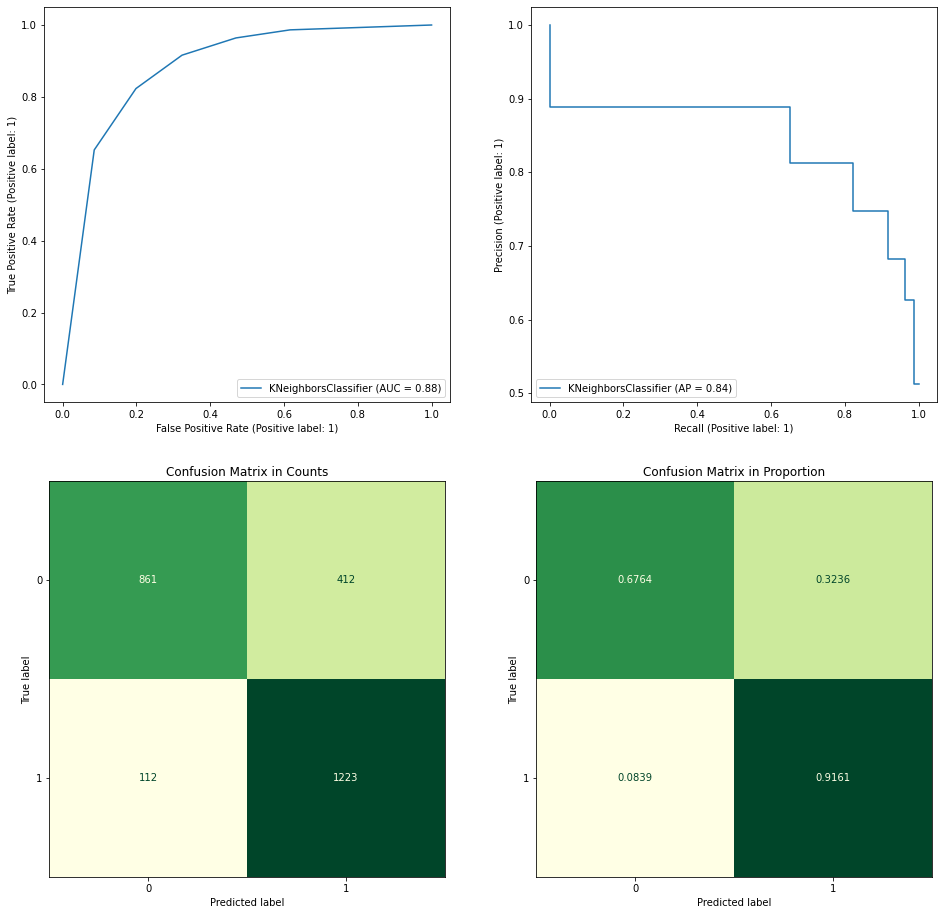

CV mean score of Training dataset:  0.785864700377761
CV mean score of Testing dataset:  0.6533714268905214


In [633]:
# Running KNN model after removing outliers

get_best_params_knn(X_train, X_test, y_train, y_test)

In [634]:
# Transformation

X = min_max_scaling(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)

K-NEAREST NEIGHBORS
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters:  {'algorithm': 'auto', 'n_neighbors': 2, 'weights': 'uniform'}
K-NEAREST NEIGHBORS
Training score:  0.8178680981595092
Accuracy:  0.8178680981595092


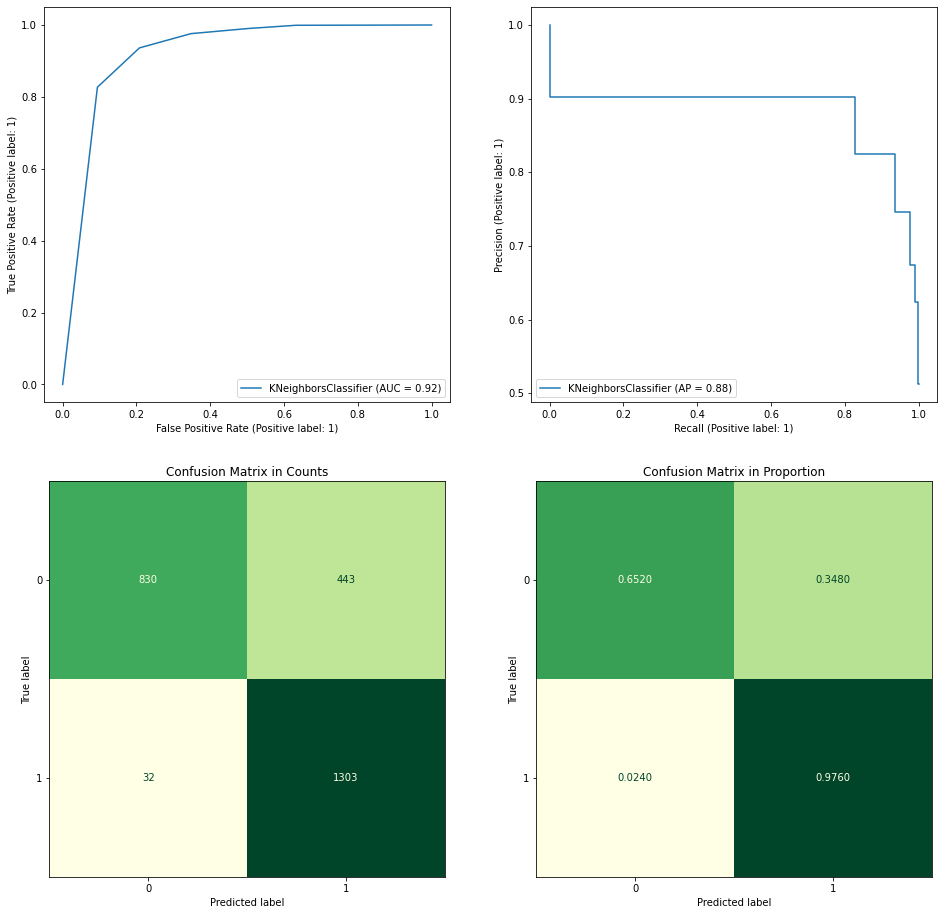

CV mean score of Training dataset:  0.8108928082845326
CV mean score of Testing dataset:  0.7331244806259698


In [635]:
# Running KNN after applying min max transformer

get_best_params_knn(X_train, X_test, y_train, y_test)

In [ ]:
########################################################################################

# FEATURE SELECTION USING BACKWARD SELECTION

########################################################################################

In [636]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression

X = df.drop('match', axis=1)
y = df['match']

lreg = LinearRegression()
sfs1 = sfs(lreg, k_features=10, forward=False, verbose=1, scoring='neg_mean_squared_error')
sfs1 = sfs1.fit(X, y)

feat_names = list(sfs1.k_feature_names_)
print(feat_names)

df_subset = df[feat_names]
df_subset['match'] = df['match']

df_subset.shape



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:    3.0s finished
Features: 56/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:    2.1s finished
Features: 55/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    1.6s finished
Features: 54/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    1.6s finished
Features: 53/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    1.4s finished
Features: 52/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    1.3s finished
Features: 51/10[Par

['attr_o', 'fun_o', 'amb_o', 'shar_o', 'diff_age', 'field_cd', 'attr', 'fun', 'amb', 'shar']


/var/folders/z5/nh_hftln6w5bwkr7w4q3q4380000gn/T/ipykernel_55007/1551009362.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['match'] = df['match']


(8368, 11)

K-NEAREST NEIGHBORS
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters:  {'algorithm': 'auto', 'n_neighbors': 11, 'weights': 'distance'}
K-NEAREST NEIGHBORS
Training score:  0.8393070489844683
Accuracy:  0.8393070489844683


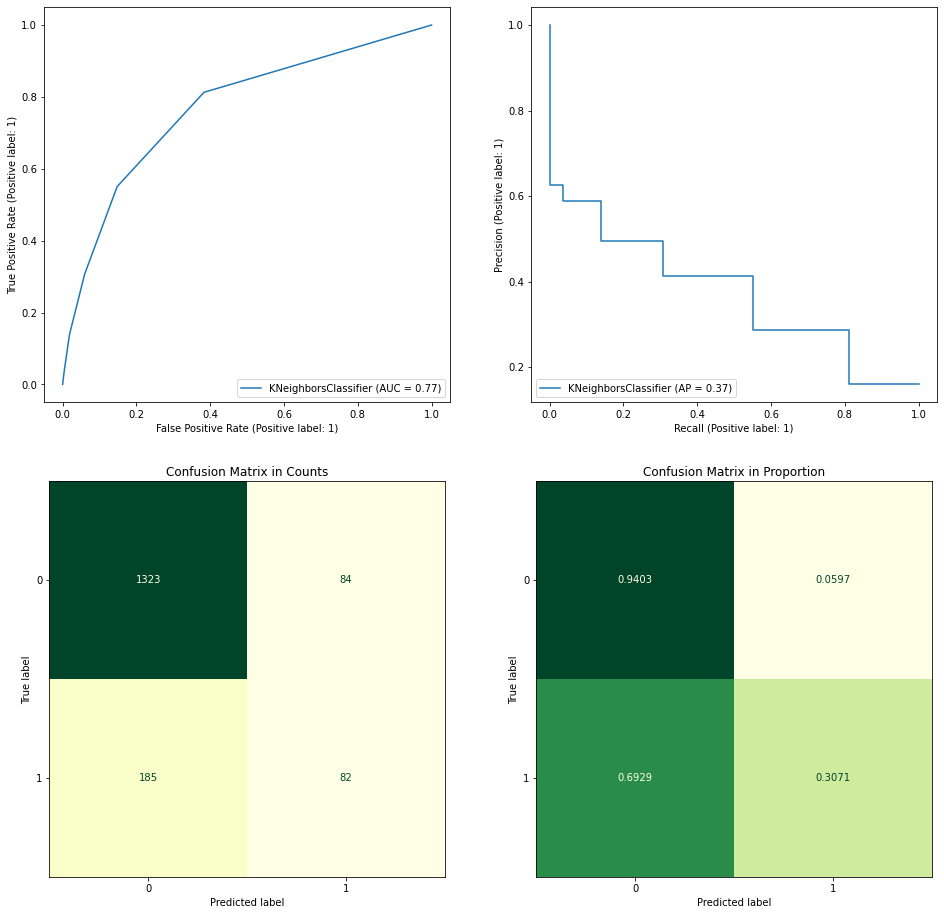

CV mean score of Training dataset:  0.8374654355759322
CV mean score of Testing dataset:  0.8428903387255341


In [637]:
# Running KNN after feature selection using backward selection

X = df_subset.drop('match', axis=1)
y = df_subset['match']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)
get_best_params_knn(X_train, X_test, y_train, y_test)

In [638]:
# Removing outliers

X,y = remove_outliers(df_subset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)

(8368, 11)
(6546, 11)
(6546, 10) (6546,)


K-NEAREST NEIGHBORS
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters:  {'algorithm': 'ball_tree', 'n_neighbors': 16, 'weights': 'uniform'}
K-NEAREST NEIGHBORS
Training score:  0.8809160305343512
Accuracy:  0.8809160305343512


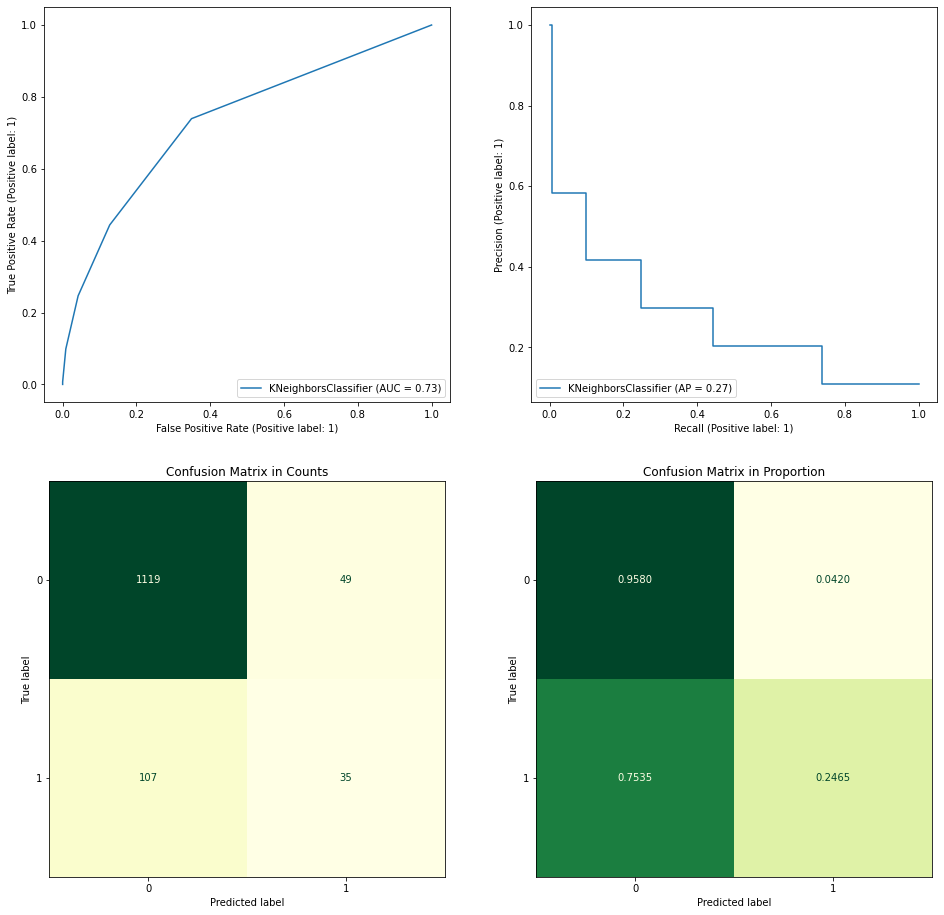

CV mean score of Training dataset:  0.8850271951121707
CV mean score of Testing dataset:  0.8740458015267176


In [639]:
# Running KNN after removing outliers

get_best_params_knn(X_train, X_test, y_train, y_test)

In [640]:
# Applying SMOTE

X,y = apply_smote(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)

(11682, 10)
(11682,)


K-NEAREST NEIGHBORS
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters:  {'algorithm': 'auto', 'n_neighbors': 2, 'weights': 'uniform'}
K-NEAREST NEIGHBORS
Training score:  0.8639281129653402
Accuracy:  0.8639281129653402


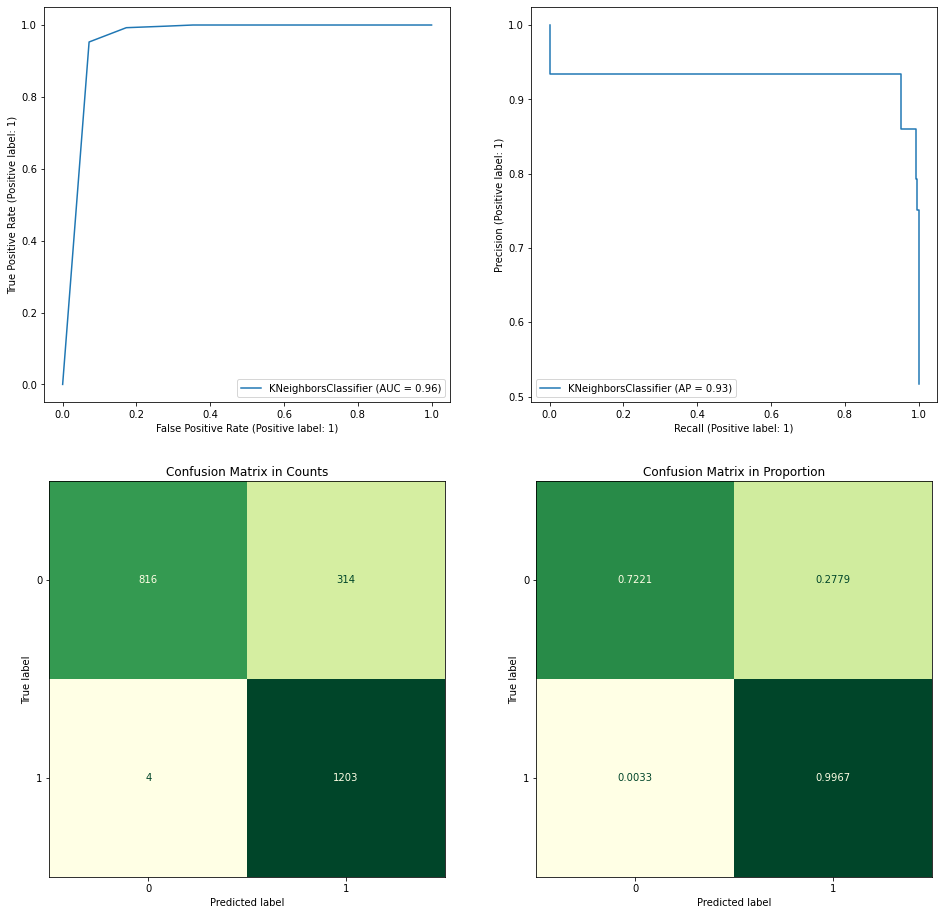

CV mean score of Training dataset:  0.8491171749598717
CV mean score of Testing dataset:  0.7950401727703655


In [641]:
# Running KNN after applying SMOTE

get_best_params_knn(X_train, X_test, y_train, y_test)

In [642]:
# Transformation

X = min_max_scaling(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)

K-NEAREST NEIGHBORS
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters:  {'algorithm': 'auto', 'n_neighbors': 2, 'weights': 'uniform'}
K-NEAREST NEIGHBORS
Training score:  0.8716302952503209
Accuracy:  0.8716302952503209


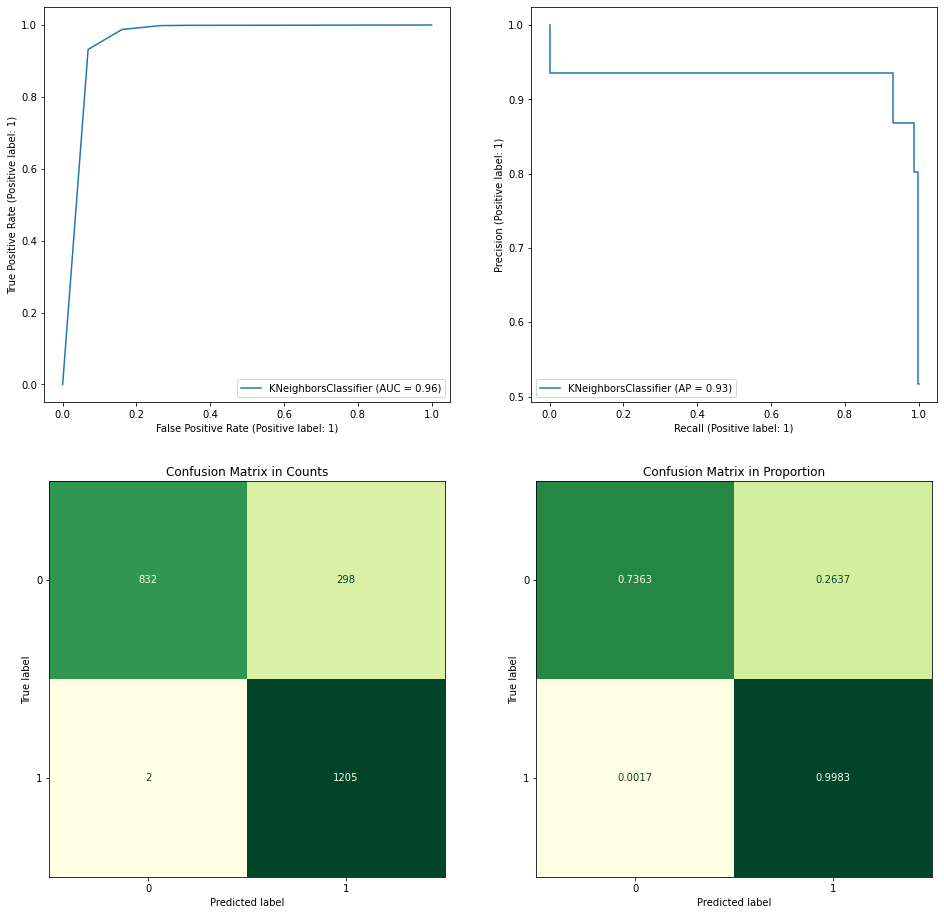

CV mean score of Training dataset:  0.8568218298555376
CV mean score of Testing dataset:  0.8143020553084792


In [643]:
# Running KNN after applying min max scaling

get_best_params_knn(X_train, X_test, y_train, y_test)

# Random Forest

In [644]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def random_forest_model(X_train, X_test, y_train, y_test, n_estimators, criterion, min_samples_split, min_samples_leaf):
    print("RANDOM FOREST CLASSIFIER") 
    model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = model.score(X_train, y_train)
    print("Training score: ", score)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy: ", acc)
    display_confusion_matrix(model, X_test, y_test)
    training_cv_score = get_cv_score(knn, X_train, y_train)
    print("CV mean score of Training dataset: ", training_cv_score)
    testing_cv_score = get_cv_score(knn, X_test, y_test)
    print("CV mean score of Testing dataset: ", testing_cv_score)

In [645]:
#Getting best parameters to perform random forest- Hyper Parameter Tuning

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV



def get_best_params_random_forest(X_train, X_test, y_train, y_test):
    
    k_range = list(range(1, 31))
    param_grid = {'n_estimators':[50,100,200,500], 'criterion':('gini', 'entropy', 'log_loss'), 'min_samples_split':[2,5,10], 'min_samples_leaf':[1,2,3]},
    print("RANDOM FOREST")
    random_forest = RandomForestClassifier()
    grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='accuracy', return_train_score=False,verbose=1)
    grid_search.fit(X_train, y_train)
    print('Best parameters: ', grid_search.best_params_)
    best_params = grid_search.best_params_
    print(best_params)
    random_forest_model(X_train, X_test, y_train, y_test, best_params['n_estimators'], best_params['criterion'], 
                        best_params['min_samples_split'], best_params['min_samples_leaf'])
    
    

RANDOM FOREST CLASSIFIER
Training score:  1.0
Accuracy:  0.8643966547192353


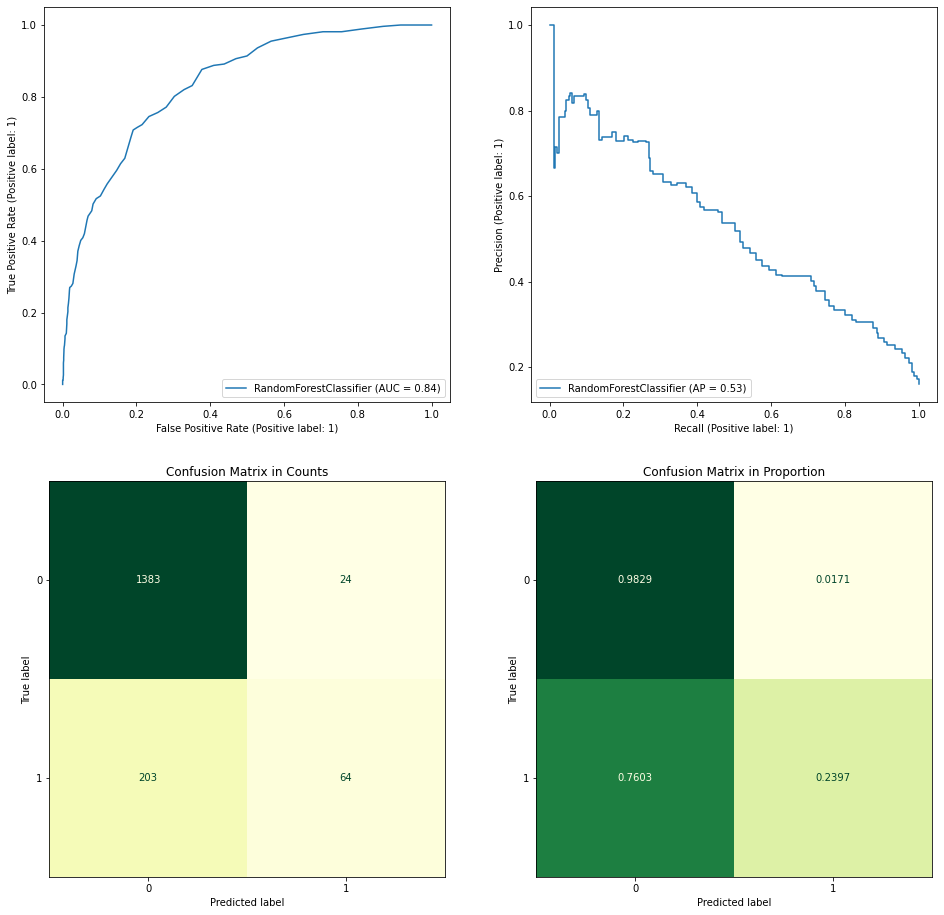

CV mean score of Training dataset:  0.8137135782788618
CV mean score of Testing dataset:  0.8177996246313344


In [646]:
# Running random forest without any preprocessing

X = df.drop('match', axis=1)
y = df['match']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)
random_forest_model(X_train, X_test, y_train, y_test, 100, 'gini', 2, 1)

In [647]:
# Removing outliers

X,y = remove_outliers(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)


(8368, 58)
(7425, 58)
(7425, 57) (7425,)


RANDOM FOREST
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters:  {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RANDOM FOREST CLASSIFIER
Training score:  1.0
Accuracy:  0.8619528619528619


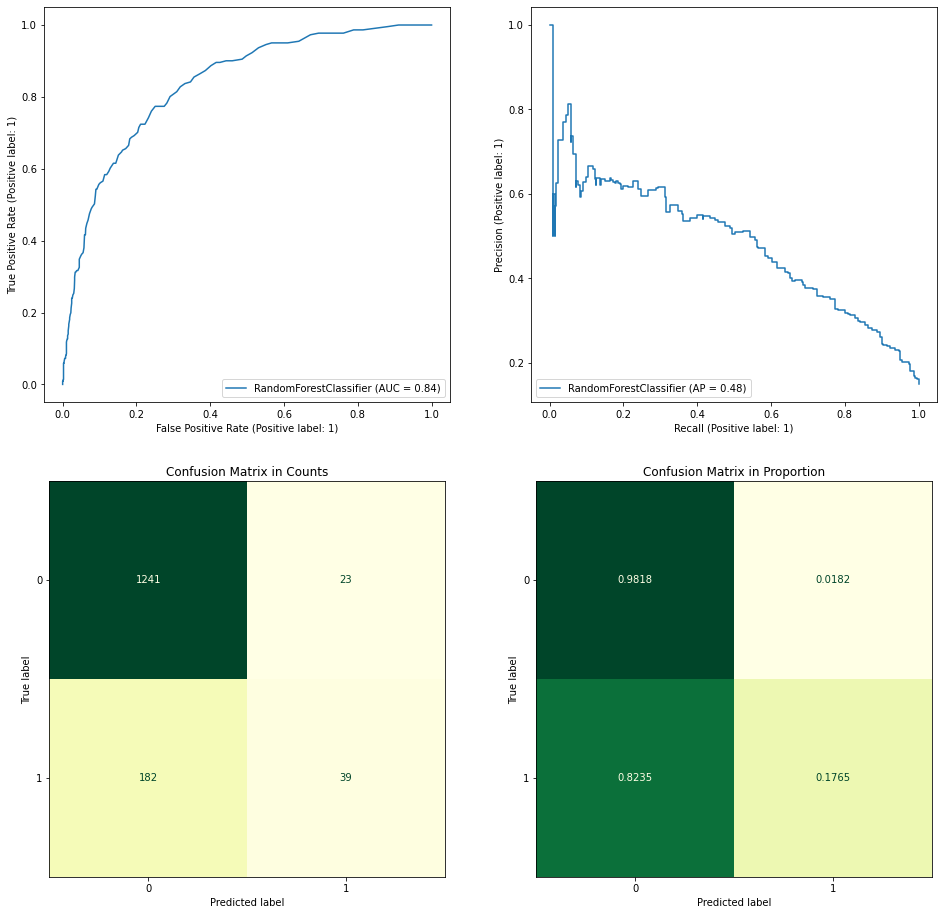

CV mean score of Training dataset:  0.8218855218855218
CV mean score of Testing dataset:  0.8343434343434344


In [648]:
# Running random forest after removing outliers

get_best_params_random_forest(X_train, X_test, y_train, y_test)

In [649]:
# Applying SMOTE

X,y = apply_smote(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)

(12562, 57)
(12562,)


RANDOM FOREST
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters:  {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST CLASSIFIER
Training score:  0.9999004876107075
Accuracy:  0.9323517707918823


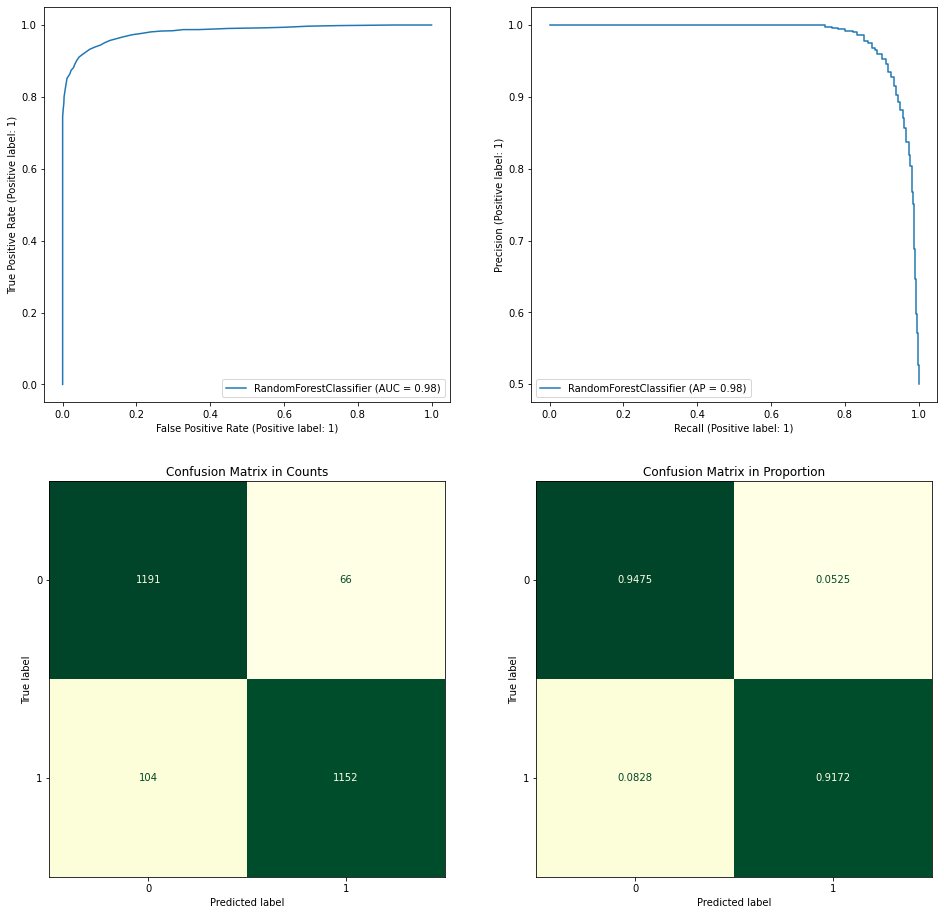

CV mean score of Training dataset:  0.7742074099388573
CV mean score of Testing dataset:  0.6410667469287858


In [650]:
# Running random forest after applying SMOTE

get_best_params_random_forest(X_train, X_test, y_train, y_test)

In [651]:
# Transformation

X = min_max_scaling(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)

RANDOM FOREST
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters:  {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RANDOM FOREST CLASSIFIER
Training score:  1.0
Accuracy:  0.9331476323119777


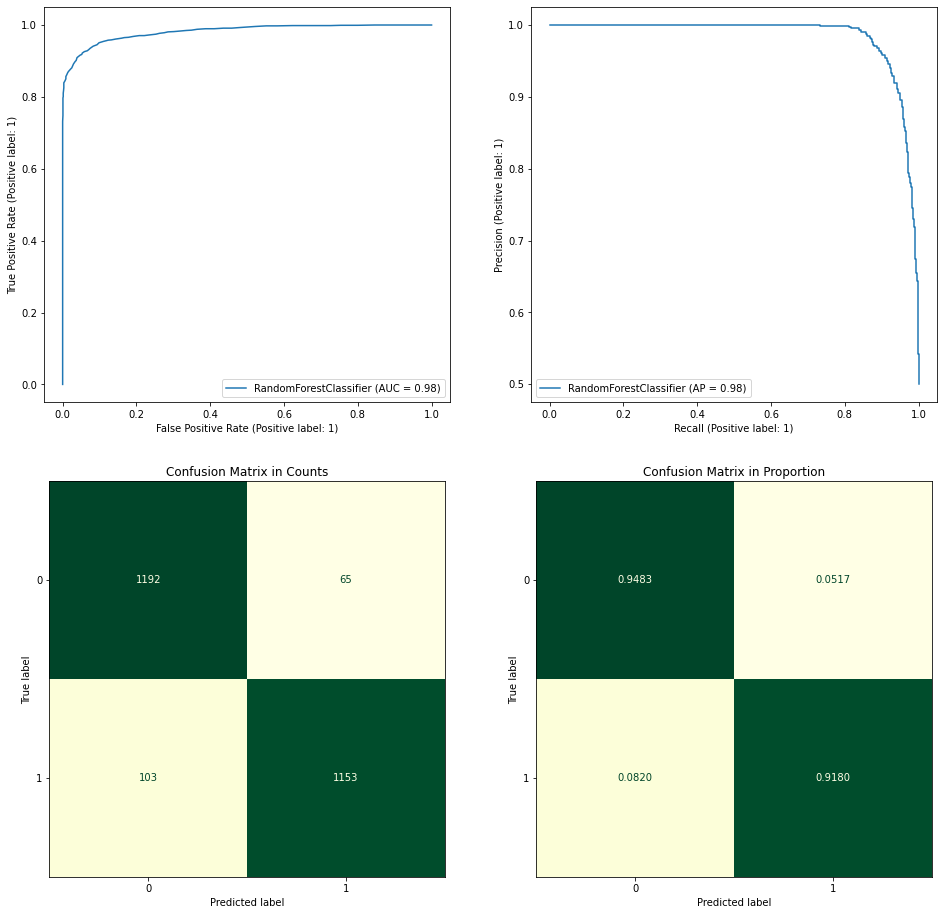

CV mean score of Training dataset:  0.8108272475353446
CV mean score of Testing dataset:  0.7075190292507901


In [652]:
# Running random forest after min max scaling

get_best_params_random_forest(X_train, X_test, y_train, y_test)